In [1]:
# 환경 설정
from dotenv import load_dotenv
import os
import pandas as pd
from ai_agent_v2 import DataAnayticsAssistant

# OpenAI API 키 로드
load_dotenv()
openai_api_key = os.getenv('OPENAI_API_KEY')

PROCESSED_DATA_PATH = "../output/stage1/processed_data_info.xlsx"
mart_name = "cust_intg"
def load_processed_data_info():
    """사전에 분석된 데이터 정보 로드"""
    if not os.path.exists(PROCESSED_DATA_PATH):
        return None
    else:
        # 모든 시트 로드
        return pd.read_excel(PROCESSED_DATA_PATH, sheet_name=mart_name)

# ✅ Streamlit 실행 시 데이터 로드
mart_info = load_processed_data_info()

# 어시스턴트 초기화
assistant = DataAnayticsAssistant(openai_api_key)

df = pd.read_pickle(f'../data/{mart_name}.pkl')

# # 데이터프레임 설정
# assistant.set_active_mart(df, mart_name)

# res = assistant.ask("상관계수가 강한 연속형 변수를 10가지만 뽑아주시고 인사이트도 부탁해요.")
# res['messages'][-1].content

🔹 현재 접근 가능 마트 목록: ['cust_enroll_history', 'cust_intg', 'product_info']
✅ 그래프 컴파일 완료


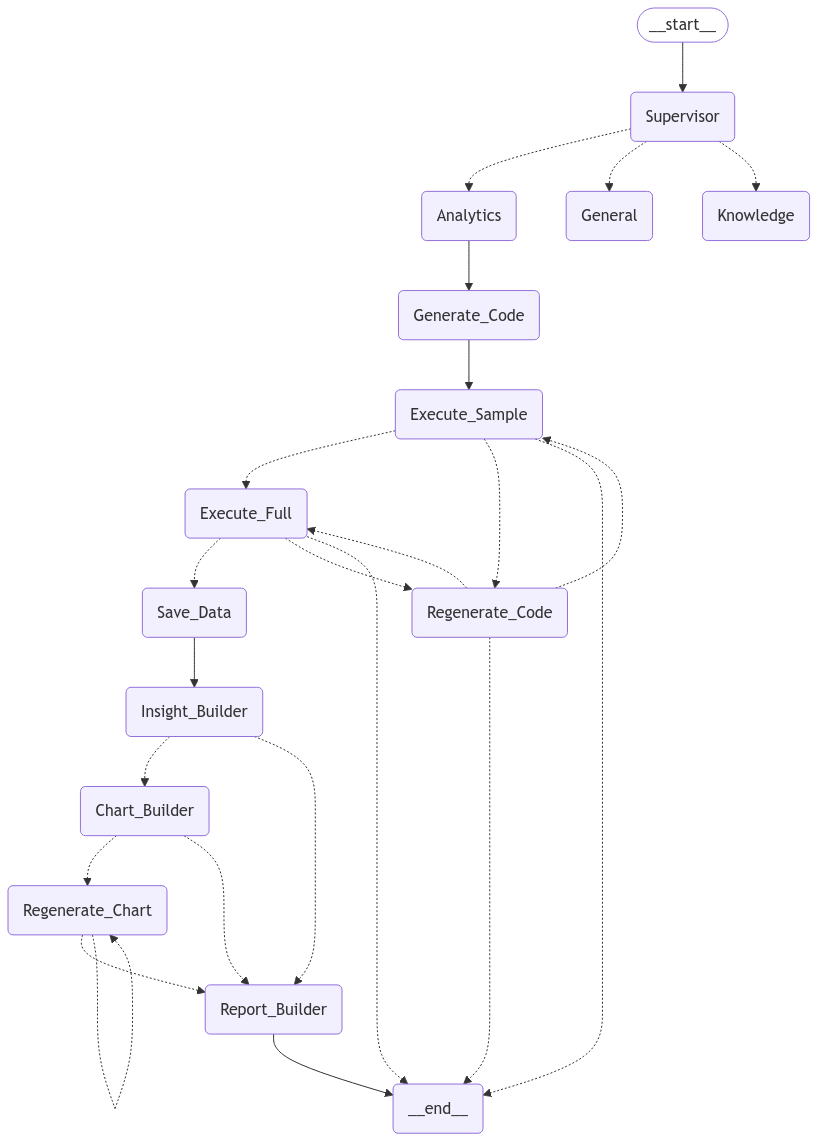

In [6]:
assistant.graph

{'original_data_head':      고객ID   나이  성별  수익자여부  CB신용평점  CB신용등급  두낫콜여부     운전코드명 성별코드  피보험자여부  ...  \
 0   25226  60대  여성      1     NaN     NaN    1.0  승용차(자가용)   02       1  ...   
 1   95256  40대  남성      1     NaN     6.0    0.0  화물차(자가용)   02       1  ...   
 2   14751  40대  여성      1     NaN     NaN    1.0       NaN   02       1  ...   
 3    4478  50대  여성      1     NaN     6.0    0.0      운전안함   01       1  ...   
 4  100000  50대  여성      0  245.26     NaN    NaN      운전안함   02       1  ...   
 
    변액보유여부 변액최대납입회차  변액유지계약수  변액기납입보험료  변액종신CMIP  변액종신보유여부  변액종신최대납입회차  \
 0       0    11.09      0.0   6424.05  69074.36         0        3.15   
 1       0     3.98      0.0   9592.97   2023.21         0       34.68   
 2       0     4.06      0.0  22093.94  11006.27         0        9.01   
 3       0     8.71      0.0   6071.17   6473.26         0        1.02   
 4       0     1.94      0.0  16569.67   2852.47         0       17.67   
 
    변액종신유지계약수   변액종신기납입보험료    기준년월  
 0     

In [4]:
analytic_results

import streamlit as st
df_result = pd.DataFrame(analytic_results["analytic_result"])
if df_result.shape[0] <= 10:
    st.table(df_result)
else:
    st.dataframe(df_result)

KeyError: 'analytic_result'

In [ ]:
# 연속형 변수의 이상치를 IQR을 통해 파악
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

# 이상치가 존재하는 데이터 파악
outliers = ((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)

# 이상치가 존재하는 데이터를 리스트 형태로 반환
result_df = df[outliers].round(2).head()
len(result_df.to_string())

In [ ]:
import pandas as pd
mart_name = "cust_intg"
df = pd.read_pickle(f'../data/{mart_name}.pkl')
# 연속형 변수 선택
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
exec_globals = {}
exec_globals["df"] = df

safe_locals = {}
code = """
# 연속형 변수 선택
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

# 이상치 파악
outliers = {}
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers[col] = df[(df[col] < lower_bound) | (df[col] > upper_bound)]

# 이상치가 존재하는 데이터 리스트로 반환
outlier_list = []
for col, outlier_df in outliers.items():
    if not outlier_df.empty:
        outlier_list.append(outlier_df)

# 비집계성 데이터 저장
analysis_results = [df.head().round(2) for df in outlier_list]
"""
exec(code, exec_globals, safe_locals)  # **제한된 네임스페이스에서 실행**

# 샘플 데이터 실행 시 분석 결과 추출
analysis_results = "샘플 데이터 실행 결과"

analysis_results = safe_locals.get("analysis_results", {})
analysis_results
# print(f"🔍 토큰 초과에 대한 분석 결과: {analysis_results == {} or analysis_results is None}")

In [3]:
from openpyxl import Workbook
from openpyxl.styles import Font, Alignment
from openpyxl.drawing.image import Image
from datetime import datetime
import os

# Delete existing file if exists
output_file = f"../output/Correlation Variables_{datetime.now().strftime('%Y%m%d%H%M%S')}.xlsx"
if os.path.exists(output_file):
    os.remove(output_file)

# Create a new workbook and select the active worksheet
wb = Workbook()
ws = wb.active

# Set column A width to 1 and disable gridlines
ws.column_dimensions['A'].width = 1
ws.sheet_view.showGridLines = False

# Set page margins
ws.page_margins.left = 0.5
ws.page_margins.right = 0.5
ws.page_margins.top = 0.5
ws.page_margins.bottom = 0.5

# Introduction
ws.merge_cells('B2:F2')
ws['B2'] = "상관계수가 강한 연속형 변수를 10가지만 뽑아주시고 인사이트도 부탁해요."
ws['B2'].font = Font(size=14, bold=True)
ws['B2'].alignment = Alignment(horizontal='center')

# Data Summary
ws.merge_cells('B4:F4')
ws['B4'] = "데이터 요약"
ws['B4'].font = Font(size=12, bold=True)

ws['B5'] = "변수"
ws['C5'] = "상관계수"
ws['B5'].font = Font(bold=True)
ws['C5'].font = Font(bold=True)

data = [
    ("기납입보험료합계 - CMIP", 1.00),
    ("교차채널유지계약건수 - 교차채널CMIP", 0.95),
    ("기타채널유지계약건수 - 기타채널CMIP", 0.95),
    ("아웃바운드채널유지계약건수 - 아웃바운드채널CMIP", 0.95),
    ("GA채널유지계약건수 - GA채널CMIP", 0.94),
    ("자사설계사채널유지계약건수 - 자사설계사채널CMIP", 0.93),
    ("직업위험등급코드 - CB신용등급", 0.86),
    ("CMIP - 보험연령", 0.09),
    ("기납입보험료합계 - 보험연령", 0.09),
    ("연금기납입보험료 - 보험연령", 0.09)
]

for idx, (var, corr) in enumerate(data, start=6):
    ws[f'B{idx}'] = var
    ws[f'C{idx}'] = corr

# Insights
ws.merge_cells('B17:F17')
ws['B17'] = "인사이트"
ws['B17'].font = Font(size=12, bold=True)

insights = [
    "기납입보험료합계와 CMIP 간의 상관계수는 1.00으로, 두 변수는 완벽한 양의 상관관계를 보입니다.",
    "교차채널유지계약건수와 교차채널CMIP, 기타채널유지계약건수와 기타채널CMIP, 아웃바운드채널유지계약건수와 아웃바운드채널CMIP, GA채널유지계약건수와 GA채널CMIP, 자사설계사채널유지계약건수와 자사설계사채널CMIP 간의 상관계수는 각각 0.95, 0.95, 0.95, 0.94, 0.93으로 매우 강한 양의 상관관계를 보입니다.",
    "직업위험등급코드와 CB신용등급 간의 상관계수는 0.86으로, 두 변수 간에 강한 양의 상관관계가 존재합니다.",
    "CMIP와 보험연령, 기납입보험료합계와 보험연령, 연금기납입보험료와 보험연령 간의 상관계수는 각각 0.09로 매우 낮습니다."
]

for idx, insight in enumerate(insights, start=18):
    ws[f'B{idx}'] = f"- {insight}"

# Conclusion
ws.merge_cells('B25:F25')
ws['B25'] = "결론"
ws['B25'].font = Font(size=12, bold=True)

conclusion = [
    "기납입보험료합계와 CMIP 간의 완벽한 상관관계를 활용하여, 고객의 보험료 납입 패턴을 분석하고 CMIP를 예측하는 모델을 개발할 수 있습니다.",
    "각 채널의 유지계약건수와 해당 채널의 CMIP 간의 강한 상관관계를 기반으로, 채널별로 맞춤형 마케팅 전략을 수립하여 유지계약건수를 증가시킬 수 있는 방안을 모색해야 합니다.",
    "직업위험등급코드와 CB신용등급 간의 상관관계를 활용하여, 고객의 신용등급을 예측하거나 리스크 평가에 활용할 수 있는 방안을 고려해볼 수 있습니다.",
    "보험연령과 다른 변수들 간의 낮은 상관관계를 고려하여, 보험연령이 다른 변수들에 미치는 영향을 재평가하고, 필요시 보험연령을 제외한 다른 변수들에 집중하는 전략을 검토해야 합니다."
]

for idx, concl in enumerate(conclusion, start=26):
    ws[f'B{idx}'] = f"- {concl}"

# Save the workbook
wb.save(output_file)

In [ ]:
from langchain_core.prompts import ChatPromptTemplate 
from prompt.prompts import *

llm = assistant.llm
code = res['validated_code']
prompt = ChatPromptTemplate.from_messages([
            ("system", PROMPT_REGENERATE_CODE_WHEN_TOKEN_OVER),
            ("user", "\nuser_request:\nIQR을 통해 연속형 변수의 이상치를 파악해주세요. 이상치를 파악한 뒤, 이상치가 존재하는 데이터를 리스트 형태로 반환해주세요."),
            ("user", "\noriginal_code:\n{original_code}"),
            ("user", "\nerror_message:\n{error_message}"),
    ])
chain = prompt |  llm 
error_message = f"결과 데이터 analysis_results의 적정 토큰 수를 초과하였습니다. analysis_results에 Raw 데이터 혹은 불필요한 반복 적재를 피해주세요",

response = chain.invoke({
    "user_request": PROMPT_REGENERATE_CODE_WHEN_TOKEN_OVER,
    "error_message": error_message,
    "original_code": code,
})
print(response.content)
exec(response.content.split("```python")[1].split("```")[0])
token_count = llm.get_num_tokens(str(analysis_results))
print(f"🔄 결과 데이터 토큰 수: {token_count}")
analysis_results

In [ ]:
def summarize_analysis_results(analysis_results):
    """analysis_results의 내용을 요약하여 토큰 수를 절감"""
    summarized_results = {}
    
    for key, value in analysis_results.items():
        print(f'key : {key}, type : {type(value)}')
        token_count = llm.get_num_tokens(str(value))
        print(f'token_count : {token_count}')
        if isinstance(value, pd.DataFrame):
            # 집계 데이터는 그대로 유지, 비집계 데이터는 샘플링 후 요약
            summarized_results[key] = value.describe().round(2).to_dict()
        elif isinstance(value, dict):
            summarized_results[key] = {k: v for k, v in list(value.items())[:10]}  # 10개 항목만 유지
        elif isinstance(value, str):
            summarized_results[key] = value[:1000]  # 문자열 데이터는 앞 1000자만 유지
        else:
            summarized_results[key] = value  # 기본 값 유지

    return summarized_results

summr = summarize_analysis_results(analysis_results)

In [ ]:
import pandas as pd
import os
from openpyxl import Workbook
from openpyxl.drawing.image import Image
from openpyxl.utils.dataframe import dataframe_to_rows
import time
from datetime import datetime
from uuid import uuid4

data = [
    ("데이터 품질" , "CMIP 평균을 구해줘"),
]
df_questions = pd.DataFrame(data, columns=["분류", "질문"])

# 결과 리스트 초기화
results = []

# 엑셀 파일 저장 경로
excel_filename = f"../output/stage1/analysis_results_xlsx_{datetime.now().strftime('%Y%m%d_%H%M%S')}.xlsx"

# 반복문으로 결과 저장
for index, row in df_questions.iterrows():
    question = row["질문"]

    start_time = time.time()
    timeout_flag = False

    try:
        # AI Assistant 실행
        result = assistant.ask(question)

        elapsed_time = time.time() - start_time
        if elapsed_time > 300:
            timeout_flag = True
            result = {"error_message": "Timeout occurred. Execution took too long."}

    except Exception as e:
        print(f"⚠️ 오류 발생: {e}")
        result = {"error_message": str(e)}   

    # 차트 이미지 경로가 존재하면 실제 파일명을 유지
    chart_display = result.get('chart_filename', 'N/A') if result.get('chart_filename') not in [None, 'N/A'] else "N/A"

    # 결과 정리
    values = [
            row['분류'],
            result.get('messages')[0].content if result.get('messages') and len(result['messages']) > 0 else 'N/A',
            "Timeout" if timeout_flag else ("Failed" if not result.get('validated_code') else "Completed"),
            result.get('validated_code', result.get('generated_code', 'N/A')),
            'df_결과',
            result.get('insights', 'N/A'),
            result.get('chart_needed', 'N/A'),
            result.get('chart_filename', 'N/A'),
            chart_display,  # ✅ 실제 이미지 경로 저장
            result.get('report_filename', 'N/A'),
            result.get('data_id', 'N/A'),
    ]
    results.append(values)
    # print(f'analysis result : {results}')

# 데이터프레임 생성
df_results = pd.DataFrame(results, columns=[
    '분류', '메시지', '상태', '검증된 코드', 'df_결과', '인사이트', '차트 필요 여부', '차트 파일명', '차트 이미지', '리포트', '데이터 ID'
])

# 엑셀 파일 생성 및 데이터 저장
wb = Workbook()
ws = wb.active
ws.title = "분석 결과"

# 데이터프레임을 엑셀로 변환
for r in dataframe_to_rows(df_results, index=False, header=True):
    ws.append(r)

# ✅ 엑셀 셀 크기 조정 (F열: 차트 이미지)
ws.column_dimensions["G"].width = 30  # F열 너비 설정
for i in range(2, len(df_results) + 2):
    ws.row_dimensions[i].height = 100  # 각 행 높이 설정

# ✅ 차트 이미지 삽입 및 크기 조정
for idx, row in df_results.iterrows():
    chart_path = row['차트 파일명'] if row["차트 파일명"] else 'N/A'
    if os.path.exists(chart_path) :
        img = Image(chart_path)

        # 🔹 이미지 크기 조정 (셀 크기에 맞춤)
        img.width = 200  # 가로 크기 (픽셀)
        img.height = 100  # 세로 크기 (픽셀)

        # 🔹 엑셀 셀 위치 설정 (F열)
        ws.add_image(img, f"F{idx+2}")

# 엑셀 파일 저장
wb.save(excel_filename)

print(f"📑 분석 결과가 {excel_filename}에 저장되었습니다.")


In [ ]:
df_mart = pd.read_pickle(f'../data/cust_enroll_history.pkl')

# 데이터프레임 가정 (df_mart)
df_mart['기준년월'] = df_mart['가입년월일'].astype(str).str[:7].str.replace('-', '')

# 고객ID, 기준년월별 가입담보 여부 피벗 테이블 생성
df_pivot = df_mart.pivot_table(index=['고객ID', '기준년월'], 
                             columns='가입담보명', 
                             values='가입담보금액', 
                             aggfunc='count', 
                             fill_value=0)

# 컬럼명에서 가입담보명 인덱스 제거
df_pivot.columns.name = None

# 가입 여부를 Y/N으로 변환하고 컬럼명 변경
df_pivot = df_pivot.applymap(lambda x: 'Y' if x > 0 else 'N')
df_pivot.columns = [f'Y_{col}' for col in df_pivot.columns]
df_pivot = df_pivot.reset_index()

df_pivot['기준년월'] = df_pivot['기준년월'].astype(str).str.replace('-', '')
df['기준년월'] = df['기준년월'].astype(str).str.replace('-', '')

# 결과 확인
# df_pivot.drop(columns=['가입담보명'], inplace=True)

df_merged = pd.merge(df, df_pivot, on=['고객ID', '기준년월'], how='left')
df_merged[[x for x in df_merged.columns if 'Y_' in x]] = df_merged[[x for x in df_merged.columns if 'Y_' in x]].fillna('N')
df_merged[:100].to_csv('df_merged.csv', index=False)

In [ ]:

# 분석 요청 실행
result = assistant.ask(f"""
제공한 데이터프레임을 이용하여 아래 각 단계별 항목에 대해 차례대로 적용 및 그 결과를 정리하고, 
각 단계는 데이터 분석가가 EDA(Exploratory Data Analysis)를 수행할 때 더욱 체계적이고 심층적으로 접근할 수 있도록 해달라.

                       
1. Remove Unnecessary Columns and List Up
데이터셋에서 모든 행에 대해 동일한 값을 가지는 열(예: 모든 행이 1인 열)을 식별하고 제거하세요. 
추가적으로, 분석 목적과 무관하거나 중복된 정보를 제공하는 열도 제거 대상으로 고려하세요.
제거된 열 목록을 정리하고, 제거 이유를 간단히 설명하세요.
추가 고려사항:
열의 고유값(unique values)을 확인하여 모든 행이 동일한 값을 가지는지 검토하세요.
열의 의미와 분석 목적을 고려하여, 불필요한 열인지 판단하세요.
제거 전, 해당 열이 향후 모델링이나 분석에 사용될 가능성이 없는지 다시 한번 확인하세요.

2. Check for Missing Values
데이터셋의 각 열에 대해 결측값(missing values)이 있는지 확인하세요.
결측값이 발견된 경우, 해당 열의 데이터 분포와 결측값의 비율을 고려하여 적절한 처리 전략을 제안하세요.
단순히 0이나 평균값, 중앙값으로 대체하는 것은 지양하세요.
결측값 처리 방법: 삭제, 다중 대체법(Multiple Imputation), 예측 모델을 활용한 대체 등 상황에 맞는 방법을 선택하세요.
결측값 처리 후, 데이터의 무결성과 분석 결과에 미치는 영향을 검토하세요.
추가 고려사항:
결측값이 발생한 이유(MCAR, MAR, MNAR)를 고려하여 처리 방법을 결정하세요.
범주형 변수의 경우, "Unknown" 또는 "Missing"과 같은 새로운 카테고리를 추가하는 방법도 고려하세요.
결측값이 많은 열은 전체 데이터 품질에 영향을 미칠 수 있으므로, 열 자체를 제거하는 것도 고려하세요.

3. Data Type Consistency
데이터셋의 각 열이 올바른 데이터 타입을 가지고 있는지 확인하세요.
범주형 변수(categorical variables)는 object 또는 category 타입으로 변환하세요.
수치형 변수(numerical variables)는 int 또는 float 타입으로 변환하세요.
날짜/시간 데이터는 datetime 타입으로 변환하세요.
잘못된 데이터 타입으로 인해 발생할 수 있는 문제(예: 수치형 데이터가 문자열로 저장된 경우)를 해결하세요.
데이터 타입 변환 시, 데이터 손실이나 오류가 발생하지 않도록 주의하세요.
범주형 변수의 경우, 고유값의 수를 확인하여 적절한 인코딩 방법(예: One-Hot Encoding, Label Encoding)을 선택하세요.
데이터 타입 변환 후, 데이터의 무결성을 다시 한번 검토하세요.

4. Duplicate Rows
데이터셋에서 중복된 행(duplicate rows)이 있는지 확인하세요.
중복된 행이 발견된 경우, 해당 행을 제거하세요.
중복 행 제거 후, 데이터셋의 크기와 무결성을 검토하세요.
추가 고려사항:
중복 행을 제거하기 전, 중복이 발생한 이유를 분석하세요(예: 데이터 수집 오류, 병합 과정에서의 중복 등).
특정 열을 기준으로 중복을 판단할 경우, 해당 열의 중요성을 고려하세요.
중복 행 제거 후, 데이터셋의 균형(예: 클래스 불균형)이 깨지지 않았는지 확인하세요.

5. Outlier Detection
수치형 열에서 이상치(outliers)를 식별하세요.
이상치를 처리하기 전, 해당 열의 도메인 지식과 데이터 분포를 고려하여 이상치가 실제로 유효한 값인지 판단하세요(예: 특정 직군의 높은 연봉).
이상치 처리 방법: 제거, 변환(예: 로그 변환), 또는 별도의 범주로 처리하는 방법을 고려하세요.
이상치 처리 후, 데이터의 분포와 분석 결과에 미치는 영향을 검토하세요.
추가 고려사항:
이상치를 식별하기 위해 IQR(Interquartile Range), Z-score, 또는 시각화(예: 박스플롯)를 활용하세요.

이상치가 특정 패턴이나 의미를 가질 경우, 이를 별도로 분석하거나 모델링에 반영하세요.
이상치 처리 방법을 선택할 때, 데이터의 특성과 분석 목적을 고려하세요.
"""
)
# 결과 확인
print(result)